In [170]:
# info...

# 1. Dane **yelp_review_polarity_csv/train.csv** https://www.kaggle.com/datasets/ilhamfp31/yelp-review-dataset/data
# 2.  Negative polarity is class 1, and positive class 2




In [171]:
!pwd
import os
from google.colab import drive
drive.mount('/content/drive',force_remount=True)
os.chdir('/content/drive/My Drive/Colab Notebooks/NLP')

/content/drive/MyDrive/Colab Notebooks/NLP
Mounted at /content/drive


In [172]:
!pip install -U spacy==3.7.2 | grep -v 'already'
!python -m spacy download en_core_web_md  | grep -v 'already'

2024-01-03 21:43:13.997856: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-03 21:43:13.997905: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-03 21:43:13.999167: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-03 21:43:15.102181: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 MB 16.4 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')


In [173]:
import matplotlib.pyplot as P
import spacy
import re # wyrażenia regularne
from wordcloud import WordCloud
from tqdm import tqdm
tqdm.pandas()
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import confusion_matrix, classification_report

In [174]:
!pwd

/content/drive/My Drive/Colab Notebooks/NLP


In [175]:
import pandas as pd

In [176]:
# data = pd.read_csv('yelp_review_polarity_csv/train.csv',encoding = 'latin',names = ['target', 'text']).sample(1000)
data = pd.read_csv('yelp_review_polarity_csv/train.csv',encoding = 'latin',names = ['target', 'text'])

In [177]:
data['target'].value_counts()

1    280000
2    280000
Name: target, dtype: int64

,text
target,
1,280000
2,280000


<Axes: xlabel='target', ylabel='count'>

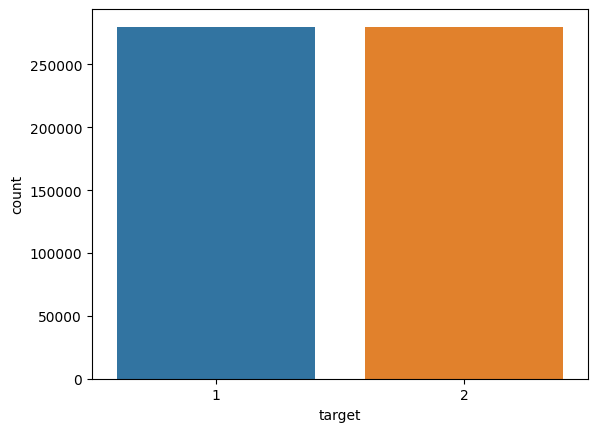

In [178]:
import seaborn as sns
display(data.groupby('target').nunique())
sns.countplot(x='target', data=data)


In [179]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 560000 entries, 0 to 559999
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   target  560000 non-null  int64 
 1   text    560000 non-null  object
dtypes: int64(1), object(1)
memory usage: 8.5+ MB


In [180]:
data[data['target']==1].sample(5)

,target,text
392225,1,I do enjoy Taco Bell from time to time but I h...
451725,1,My sister and I are pretty great guest at rest...
286059,1,Le vrai four \u00e0 bois \u00e0 l'entr\u00e9e ...
416667,1,Felt discriminated because I came there in a s...
321560,1,Absolutely AWFUL service. \nWe were originally...


In [181]:
# 2 na 0 - pozytywny wydźwięk

In [182]:
data = data[['text', 'target']]

data['target'].replace(2,0,inplace=True)
data.sample(5)

<ipython-input-182-e6dff7c88b17>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['target'].replace(2,0,inplace=True)


,text,target
185706,"I used to LOVE this show, I had a HORRIBLE exp...",1
174746,After seven years living in Charlotte and alwa...,1
250910,"An art gallery, a clothing store, a learning c...",0
447031,Let me just start by saying that the first tim...,1
504730,"Some of the best selection, service, and price...",0


# Preprocessing

In [183]:
data['text'] = data['text'].apply(lambda x: x.lower())

In [184]:
re_url = re.compile(r"((www.[^\s]+)|(https?://[^\s]+))")
data['text'] = data['text'].apply(lambda x: re_url.sub('', x))

In [185]:
re_letters = re.compile(r"[^a-z\s']")
data['text'] = data['text'].apply(lambda x: re_letters.sub('', x))

### spacy.load

In [186]:
nlp = spacy.load('en_core_web_md', disable=['ner', 'parser'])
nlp.add_pipe('sentencizer')

In [187]:
def remove_stopwords(text):
  return ' '.join(filter(lambda x: x not in nlp.Defaults.stop_words, text.split()))

data['text'] = data['text'].apply(remove_stopwords)

In [188]:
data.drop_duplicates(subset='text', keep='first', inplace=True)

In [189]:
#### below is super-time-consuming

In [ ]:
def lemmatize(text):
  return ' '.join([x.lemma_ for x in nlp(text)])
data['text'] = data['text'].progress_apply(lemmatize)

  1%|          | 4599/559237 [00:38<1:27:16, 105.91it/s]

In [ ]:
data.to_csv('sentiment_data_clean2.csv', sep='\t', index=False)

Cloud of Words

In [ ]:
text_neg = ' '.join(data[data['target']==0]['text'])
wc_neg = WordCloud(max_words = 1000, width = 1600, height = 800, collocations=False).generate(text_neg)
wc_neg.to_image()

In [ ]:
text_pos = ' '.join(data[data['target']==1]['text'])
wc_pos = WordCloud(max_words = 1000, width = 1600, height = 800, collocations=False).generate(text_pos)
wc_pos.to_image()

In [ ]:
data

# Classification

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data.text, data.target, test_size=0.1, stratify=data.target)

In [ ]:
vectorizer = TfidfVectorizer(ngram_range=(1,2), max_features=500000) # for paired values
vectorizer.fit(X_train)

In [ ]:
len(vectorizer.get_feature_names_out())

In [ ]:
X_train = vectorizer.transform(X_train)
X_test = vectorizer.transform(X_test)

In [ ]:
model = BernoulliNB()
model.fit(X_train, y_train)

### Naive Bayes

In [ ]:
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

# Podstawowa sieć RNN i Bert2




In [ ]:
!pip install -U portalocker>=2.0.0


In [ ]:
from torchtext.datasets import IMDB
from torchtext.data.utils import get_tokenizer
from torch.utils.data import random_split
from torchtext.vocab import build_vocab_from_iterator
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader
import torchdata.datapipes as dp
import torch
import torch.nn as nn
import torch.optim as optim
import time

In [ ]:
!pip install -U accelerate -q | grep -v 'already'
!pip install -U transformers -q | grep -v 'already'
!pip install -U datasets -q  | grep -v 'already'

In [ ]:
import transformers
transformers.__version__

In [ ]:
data.rename(columns={'target':'label'}, inplace=True)
data.sample(3)

In [ ]:
from datasets import Dataset

dataset_ = Dataset.from_pandas(data)
dataset = dataset_.train_test_split(0.1)

### Fine-tuning

In [ ]:
model_checkpoint = 'distilbert-base-uncased'
batch_size = 128

In [ ]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint, use_fast=True)

In [ ]:
tokenizer("This is a sample")

In [ ]:
def process(x):
  return tokenizer(x['text'])

train_ds = dataset['train'].map(process)
eval_ds = dataset['test'].map(process)

In [ ]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer

num_labels = 2
model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=num_labels)

In [ ]:
args = TrainingArguments(
    f'{model_checkpoint}_sentiment_analysis',
    evaluation_strategy = 'epoch',
    save_strategy = 'epoch',
    learning_rate = 2e-5,
    per_device_train_batch_size = batch_size,
    per_device_eval_batch_size = batch_size,
    num_train_epochs = 5,
    weight_decay = 0.01,
    load_best_model_at_end = True,
    metric_for_best_model = 'accuracy'
)

In [ ]:
from datasets import load_metric
import numpy as np

metric = load_metric('glue', 'sst2')

def compute_metrics(eval_preds):
  logits, labels = eval_preds
  predictions = np.argmax(logits, axis=-1)
  return metric.compute(predictions=predictions, references=labels)

In [ ]:
trainer = Trainer(
    model,
    args,
    train_dataset=train_ds,
    eval_dataset=eval_ds,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

In [ ]:
trainer.evaluate([train_ds[0]])

In [ ]:
# trainer.train()

In [ ]:
trainer.model

# BERT z dofitowanym gotowym tokenizatorem

In [ ]:
!pwd
import os
from google.colab import drive
drive.mount('/content/drive',force_remount=True)
os.chdir('/content/drive/My Drive/Colab Notebooks/NLP')

In [ ]:
import torch

SEED = 42

# seed dla PyTorch
torch.manual_seed(SEED)
if torch.cuda.is_available():
 torch.cuda.manual_seed(SEED)
 torch.cuda.manual_seed_all(SEED)
 torch.backends.cudnn.deterministic = True
 torch.backends.cudnn.benchmark = False

In [ ]:
from transformers import DistilBertTokenizer, DistilBertModel,  RobertaModel, RobertaTokenizer
from torch.utils.data import random_split
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
import time

In [ ]:
import csv

def read_tsv(filename):
 data = []

 with open(filename, 'r', encoding='utf-8') as f:
  reader = csv.reader(f, delimiter='\t')
  for row in reader:
    data.append(tuple(row))

 return data

filename = "sentiment_data_clean2.csv"
data_list = read_tsv(filename)
data_list[0]

In [ ]:
split_ratio = 0.2
n_train = len(data_list)
n_test = int(n_train * split_ratio)
n_train = n_train - n_test
train_data, test_data = random_split(data_list, [n_train, n_test])

In [ ]:
label_pipeline = lambda x: 1 if x == '1' else 0

def collate_batch(batch):
 label_list, text_list = [], []
 for (_text, _label) in batch:
  label_list.append(label_pipeline(_label))
  text_list.append(_text)
 return torch.tensor(label_list, dtype=torch.float32), text_list

In [ ]:
batch_size = 64

val_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=False, collate_fn=collate_batch)
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True, collate_fn=collate_batch)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# import torch

# class RNN(nn.Module):

#   def __init__(self, hidden_dim, output_dim):
#     super().__init__()


#     # self.tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased') #roberta-base , t5-small
#     # self.distilbert = DistilBertModel.from_pretrained('distilbert-base-uncased') #distilbert-base-uncased


#     self.tokenizer =    RobertaTokenizer.from_pretrained('roberta-base') #roberta-base , t5-small
#     self.distilbert2 =    RobertaTokenizer.from_pretrained('roberta-base') #distilbert-base-uncased

#     embedding_dim = self.distilbert2.config.hidden_size
#     # embedding_dim = model.config.hidden_size

#     self.rnn = nn.RNN(embedding_dim, hidden_dim, batch_first=True)
#     self.fc = nn.Linear(hidden_dim, output_dim)

#   def forward(self, text, text_length=None):
#     inputs = self.tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=512, return_length=True)
#     attention_mask = inputs['attention_mask'].to(device)
#     input_ids = inputs['input_ids'].to(device)

#     with torch.no_grad():
#       embedded = self.distilbert2(input_ids, attention_mask=attention_mask).last_hidden_state

#     outputs, hidden = self.rnn(embedded)
#     return self.fc(hidden.squeeze(0))

In [ ]:
# hidden_dim = 256
# output_dim = 1

# model = RNN(hidden_dim, output_dim)

In [ ]:
import torch
import torch.nn as nn
from transformers import RobertaTokenizer, RobertaModel

class RNN(nn.Module):
    def __init__(self, hidden_dim, output_dim):
        super().__init__()

        self.tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
        self.roberta = RobertaModel.from_pretrained('roberta-base')

        embedding_dim = self.roberta.config.hidden_size

        self.rnn = nn.RNN(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, text, text_length=None):
        inputs = self.tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=512, return_attention_mask=True)
        attention_mask = inputs['attention_mask'].to(self.roberta.device)
        input_ids = inputs['input_ids'].to(self.roberta.device)

        with torch.no_grad():
            embedded = self.roberta(input_ids, attention_mask=attention_mask)[0]

        outputs, hidden = self.rnn(embedded)
        return self.fc(hidden.squeeze(0))

# Define the dimensions
hidden_dim = 256
output_dim = 1

# Create the model instance
model = RNN(hidden_dim, output_dim)


In [ ]:
def count_parameters(model):
 return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'Model ma {count_parameters(model):,} parametrów')

In [ ]:
optimizer = optim.SGD(model.parameters(), lr=1e-3)
criterion = nn.BCEWithLogitsLoss()
model = model.to(device)
criterion = criterion.to(device)

In [ ]:
def binary_accuracy(preds, y):
  rounded_preds = torch.round(torch.sigmoid(preds))
  correct = (rounded_preds == y).float()
  acc = correct.sum() / len(correct)
  return acc

def train(model, iterator, optimizer, criterion):
  epoch_loss = 0
  epoch_acc = 0
  model.train()

  for batch in iterator:
    labels, texts = batch
    labels = labels.to(device)
    optimizer.zero_grad()

    predictions = model(texts).squeeze(1)
    loss = criterion(predictions, labels)
    acc = binary_accuracy(predictions, labels)

    loss.backward()
    optimizer.step()

    epoch_loss += loss.item()
    epoch_acc += acc.item()

  return epoch_loss / len(iterator), epoch_acc / len(iterator)

def evaluate(model, iterator, criterion):
  epoch_loss = 0
  epoch_acc = 0
  model.eval()

  with torch.no_grad():
    for batch in iterator:
      labels, texts = batch
      labels = labels.to(device)

      predictions = model(texts).squeeze(1)
      loss = criterion(predictions, labels)
      acc = binary_accuracy(predictions, labels)

      epoch_loss += loss.item()
      epoch_acc += acc.item()

  return epoch_loss / len(iterator), epoch_acc / len(iterator)

def epoch_time(start_time, end_time):
  elapsed_time = end_time - start_time
  elapsed_mins = int(elapsed_time / 60)
  elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
  return elapsed_mins, elapsed_secs

In [ ]:
N_EPOCHS = 5
best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
  start_time = time.time()

  train_loss, train_acc = train(model, train_dataloader, optimizer, criterion)
  valid_loss, valid_acc = evaluate(model, val_dataloader, criterion)

  end_time = time.time()
  epoch_mins, epoch_secs = epoch_time(start_time, end_time)

  if valid_loss < best_valid_loss:
    best_valid_loss = valid_loss
    torch.save(model.state_dict(), 'rnn-model.pt')

  print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
  print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
  print(f'\t Val. Loss: {valid_loss:.3f} | Val. Acc: {valid_acc*100:.2f}%')

In [ ]:
# Simple RNN

In [ ]:
!pip install -U portalocker | grep -v 'already'
!python -m spacy download en_core_web_sm  | grep -v 'already'


In [ ]:
from torchtext.data.utils import get_tokenizer
tokenizer = get_tokenizer('spacy', 'en_core_web_sm')

def yield_tokens(data_iter):
  for _, text in data_iter:
    return tokenizer(text)

In [ ]:
from torchtext.datasets import IMDB
from torchtext.vocab import build_vocab_from_iterator


train_iter, test_iter = IMDB(split=('train', 'test'))

MAX_TOKENS = 25000

vocab = build_vocab_from_iterator( [yield_tokens(train_iter)], specials=['<unk>'], max_tokens=MAX_TOKENS)
vocab.set_default_index(vocab['<unk>'])

In [ ]:
text_pipeline = lambda x: vocab(tokenizer(x))
label_pipeline = lambda x: 1 if x == '1' else 0

def collate_batch(batch):
  label_list, text_list, lenghts = [], [], []
  for _text, _label in batch:
    label_list.append(label_pipeline(_label))
    processed_text = torch.tensor(text_pipeline(_text), dtype=torch.int64)
    text_list.append(processed_text)
    lenghts.append(processed_text.size(0))

  label_list = torch.tensor(label_list, dtype=torch.float32)
  lenghts = torch.tensor(lenghts, dtype=torch.int64)
  text_list = pad_sequence(text_list, batch_first=True)
  return label_list, text_list, lenghts

In [ ]:
batch_size = 64
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=False, collate_fn=collate_batch)
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True, collate_fn=collate_batch)

In [ ]:
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

class RNN(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim):
      super().__init__()
      self.embedding = nn.Embedding(input_dim, embedding_dim)
      self.rnn = nn.RNN(embedding_dim, hidden_dim)
      self.lstm = nn.LSTM(
          embedding_dim,
          hidden_dim,
          num_layers=3,
          bidirectional=True,
          dropout=0.3
      )
      self.fc = nn.Linear(hidden_dim, output_dim)


    def forward(self, text, text_length):
      embedded = self.embedding(text)
      packed_embedded = pack_padded_sequence(embedded, text_length.cpu(), batch_first=True, enforce_sorted=False)
      packed_output, hidden = self.rnn(packed_embedded)
      # packed_output, hidden = self.lstm(packed_embedded)

      output, output_lengths = pad_packed_sequence(packed_output, batch_first=True)

      return self.fc(hidden.squeeze(0))

In [ ]:
INPUT_DIM = len(vocab)
EMBEDDING_DIM = 100
HIDDEN_DIM = 256
OUTPUT_DIM = 1

model = RNN(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM)

def count_parameters(model):
  return sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'Model ma {count_parameters(model):,} parametrów')

In [ ]:
optimizer = optim.SGD(model.parameters(), lr=1e-3)

In [ ]:
criterion = nn.BCEWithLogitsLoss()

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
criterion = criterion.to(device)

In [ ]:
def binary_accuracy(preds, y):
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float()
    acc = correct.sum() / len(correct)
    return acc

In [ ]:
def train(model, dataloader, optimizer, criterion):
    epoch_loss = 0
    epoch_acc = 0
    model.train()

    for batch in dataloader:
      #label_list, text_list, lenghts
      labels, texts, lengths = batch
      texts, labels = texts.to(device), labels.to(device)
      optimizer.zero_grad()

      predictions = model(texts, lengths).squeeze(1)
      loss = criterion(predictions, labels)
      acc = binary_accuracy(predictions, labels)

      loss.backward()
      optimizer.step()

      epoch_loss += loss.item()
      epoch_acc += acc.item()

    return epoch_loss / len(dataloader), epoch_acc / len(dataloader)

In [ ]:
def evaluate(model, dataloader, criterion):
    epoch_loss = 0
    epoch_acc = 0
    model.eval()

    with torch.no_grad():
      for batch in dataloader:
        labels, texts, lengths = batch
        texts, labels = texts.to(device), labels.to(device)

        predictions = model(texts, lengths).squeeze(1)
        loss = criterion(predictions, labels)
        acc = binary_accuracy(predictions, labels)

        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(dataloader), epoch_acc / len(dataloader)

In [ ]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [ ]:
train_dataloader


In [ ]:
N_EPOCHS = 6
best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
  start_time = time.time()

  train_loss, train_acc = train(model, train_dataloader, optimizer, criterion)
  valid_loss, valid_acc = evaluate(model, test_dataloader, criterion)

  end_time = time.time()

  if valid_loss < best_valid_loss:
    best_valid_loss = valid_loss
    torch.save(model.state_dict(), 'rnn_model.pt')

  epoch_mins, epoch_secs = epoch_time(start_time, end_time)

  print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
  print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
  print(f'\t Val. Loss: {valid_loss:.3f} | Val. Acc: {valid_acc*100:.2f}%')